# LAB 4. NON-PARAMETRIC METHODS

This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es) and [oscar.barquero@urjc.es](mailto:oscar.barquero@urjc.es)

UPDATE: 22nd Nov 2023

In this notebook we will analyze and compare different non-parametric methods over the `pima_indian_diabetes` dataset. Specifically, we will learn:

- How to train $K-$NN, DTs, Random Forest, Gradient Boosting and MLP algorithms.
- How to set their hyperparameters (model selection)
- How to evaluate and compare their performance (model evaluation)


In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 0. Load the data 

In [59]:
X = pd.read_csv("X_resampled.csv")
y = pd.read_csv("Y_resampled.csv")
# take a look to the data
y.head()

,Outcome
0,1
1,0
2,1
3,0
4,0


# 1. Model Selection and evaluation on $K-$NN

We will focus first on the **classification task**, using `Outcome` as target

First, we split our data, but we do it wisely in order build a test set as similar as the train set. Since our target variables is *imbalaced* we might want to activate the `stratify` option.

Take a look to the function documentation: [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('- Train size:', X_train.shape)
print('- Test size:', X_test.shape)

print('\n- Train target distribution: ', y_train.value_counts().values/len(y_train))
print('- Test target distribution:  ',y_test.value_counts().values/len(y_test))

- Train size: (666, 8)
- Test size: (286, 8)

- Train target distribution:  [0.50750751 0.49249249]
- Test target distribution:   [0.51748252 0.48251748]


<div class = "alert alert-success">
Run the above cell several times, does the target variable distribution change?
</div>

Yes it does change. But not if you use random_state parameter. 

### Standarize/normalize variables

$K-$NN and MLP require the input data to be standarized

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

## 1.1 Let's set a baseline

Before running our algorithms it is always a good practice to build a baseline model, so you we have a reference of what the results should be.

- In `src.utils` you have implemented some functions to help us calculating and representing different classification metrics. 

- The `analyze_train_test_performance` function provides a comparative summary between training and test metrics.

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	72.67	69.93
SEN:	71.95	66.22
ESP:	73.37	73.91
PPV:	72.39	73.13
F1:	72.17	69.50


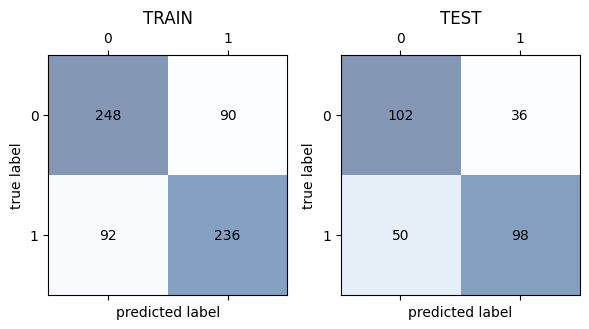

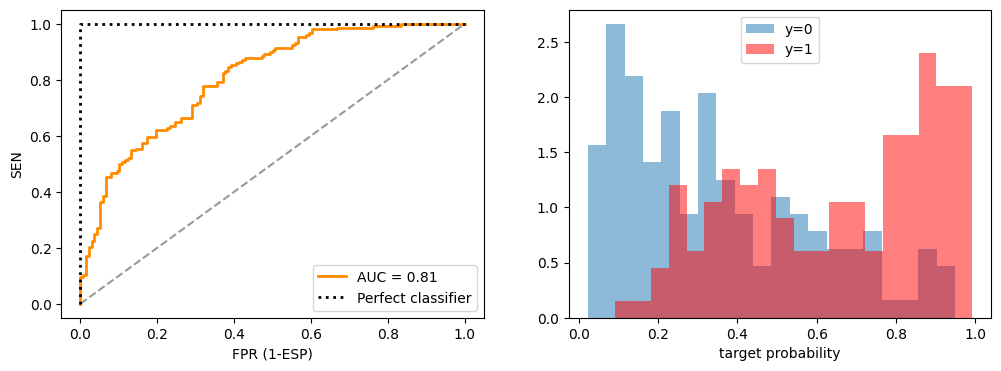

In [62]:
from sklearn.linear_model import LogisticRegression
from src.utils import analyze_train_test_performance  
y_train = y_train.values.reshape(-1, 1).ravel() 
y_test = y_test.values.reshape(-1, 1).ravel()
# Logistic regression
lr_model = LogisticRegression().fit(X_train_norm,y_train)

# This a custom function, take a look in src.utils
analyze_train_test_performance(lr_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">
Does this model overfit? Justify your answer
</div>

Test metrics are slightly lower than training metrics so our model is overfitting. 

## 1.2 Model selection: *GridSearch* 

We are going to sweep different values of the parameters of each algorithm, to determine its optimal value. In this sweep, we will use a cross-validation strategy, but never the test set!

To do so, we will be using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) function.

In [63]:
from sklearn.model_selection import GridSearchCV

# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer = 'f1', plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])
    std_scores = grid.cv_results_['std_test_score']
    params = grid.param_grid[hyper_parameter]
    
    if log:
        params = np.log10(params)
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        plt.plot(params,scores, 'o-')
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()

#### Train an algorithm using `GridSearchCV`

We need to define:

- `scoring`: strategy to evaluate the performance of the cross-validated model on the validation sets. [Metrics in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

<div class = "alert alert-success">
Take a look to the different metrics in sklearn
</div>

- `param_grid`: dictionary with parameters names (`str`) as keys and lists of parameter settings to try as value. Example:

```python
param_grid = {'n_neighbors': range(1,25)}
```




### KNN

best mean cross-validation score: 0.812
best parameters: {'n_neighbors': 1}


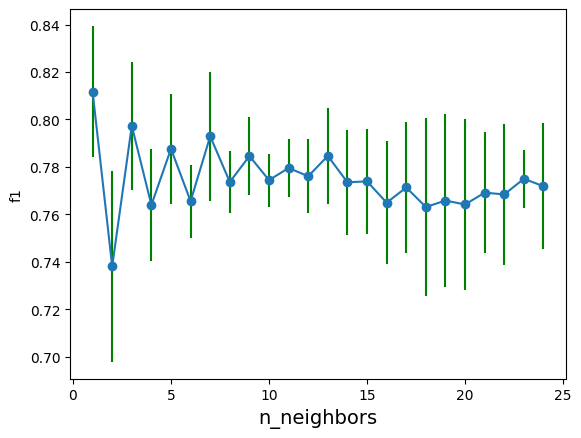

In [64]:
from sklearn.neighbors import KNeighborsClassifier

y = y.values.reshape(-1, 1).ravel() # to avoid errors

# Metric for the scoring
scorer = 'f1' #same results with 'recall'
param_grid = {'n_neighbors': range(1,25)}

estimator = KNeighborsClassifier()

X_norm = scaler.transform(X) # we have to have X normalized!!!

# param_grid
grid_knn = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors',scorer, plot_errors=True)

<div class = "alert alert-success">

Which is the optimal value for $k$? You might want to consider
    
- Different score metrics to guide the CV process<br> 
- Plot the CV errors (`plot_errors = True`) 
</div>

Does GridSearch normalizes the data? No it does not, so ensure your data is normalized before giving it. 

## 1.3 Model evaluation

Once we have selected the model (hyper)-parameters, we evaluate its performance

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	100.00	100.00
SEN:	100.00	100.00
ESP:	100.00	100.00
PPV:	100.00	100.00
F1:	100.00	100.00


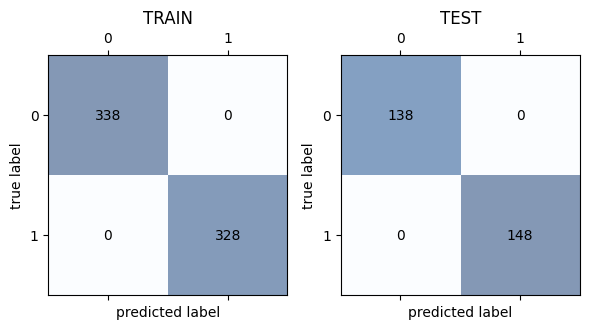

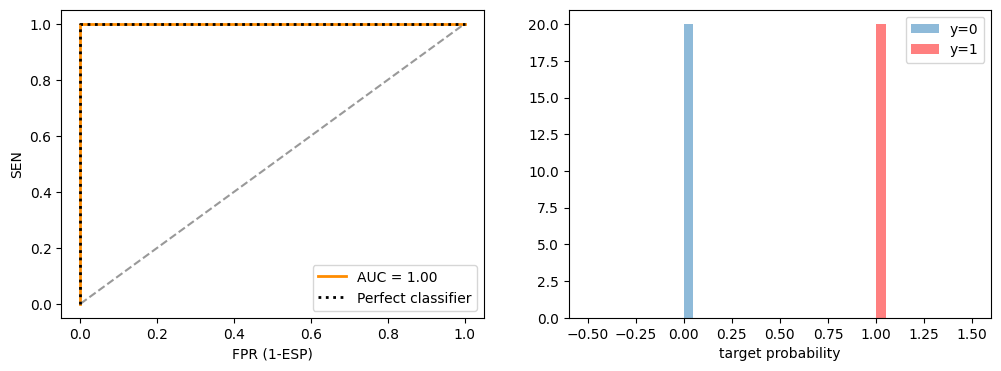

In [65]:
knn_model = grid_knn.best_estimator_
analyze_train_test_performance(knn_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">
Does this model overfit? Is it better than our baseline?
</div>

No it does not overfit (same training and testing error). Yes it is way better!

# 2. Decision trees (DTs)

We will repeat the above process for DTs. In this case, the hyper-parameter is `max_depth`.

## 2.1 Model selection

best mean cross-validation score: 0.772
best parameters: {'max_depth': 11}


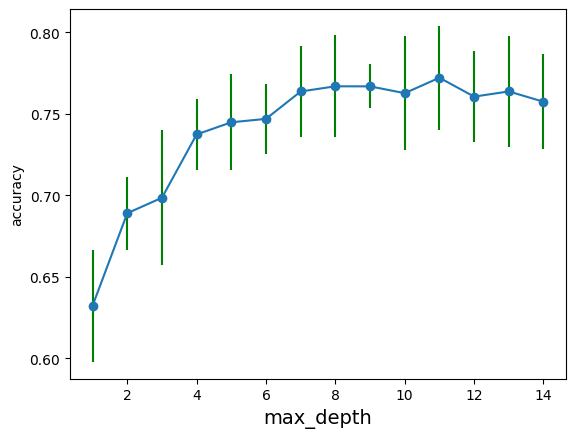

In [66]:
from sklearn.tree import DecisionTreeClassifier

# Decision trees
param_grid = {'max_depth': range(1,15)} # we can add more parameters, , 'min_samples_split': range(2,10)

scorer = 'accuracy'
estimator = DecisionTreeClassifier(random_state=0)

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt,'max_depth',scorer, plot_errors=True)


The best parameter changes (9, 10 or 11). 

best mean cross-validation score: 0.763
best parameters: {'min_samples_split': 2}


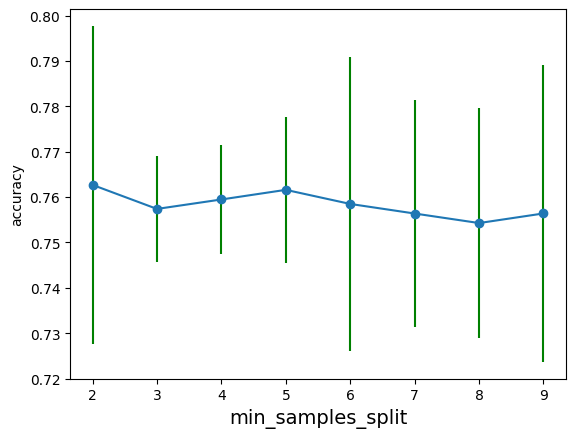

In [67]:
param_grid = {'min_samples_split': range(2,10)}

estimator = DecisionTreeClassifier(random_state=0, max_depth=10)
#HYPER PARAMETER SEARCH
grid_dt2 = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_dt2,'min_samples_split',scorer, plot_errors=True)

## 2.2 Model evaluation

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	97.30	73.78
SEN:	98.48	75.00
ESP:	96.15	72.46
PPV:	96.13	74.50
F1:	97.29	74.75


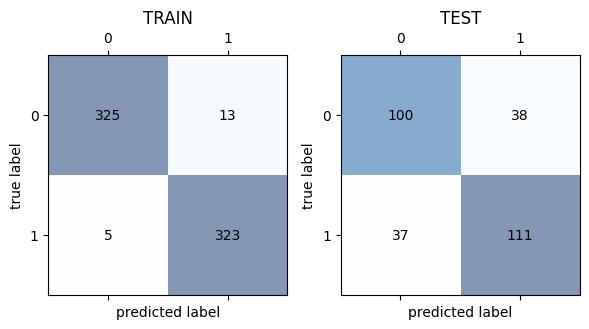

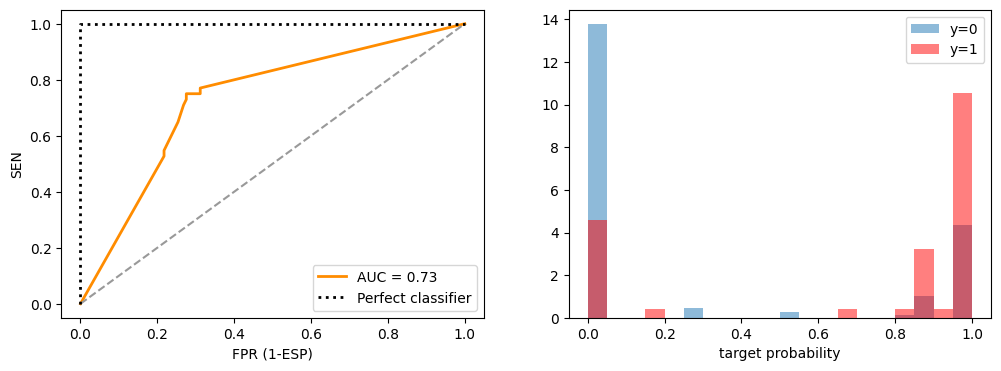

In [68]:
#dt_model = grid_dt.best_estimator_
best_max_depth = grid_dt.best_params_['max_depth']
best_min_samples_split = grid_dt2.best_params_['min_samples_split']
dt_model = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth, min_samples_split=best_min_samples_split).fit(X_train_norm,y_train)
analyze_train_test_performance(dt_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What if we change `max_depth`?

</div>

It overfits a lot. 
It is better than the logistic regression model but not than KNN. 

## 2.3 DTs visualization

Trees can be visualized using the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) function

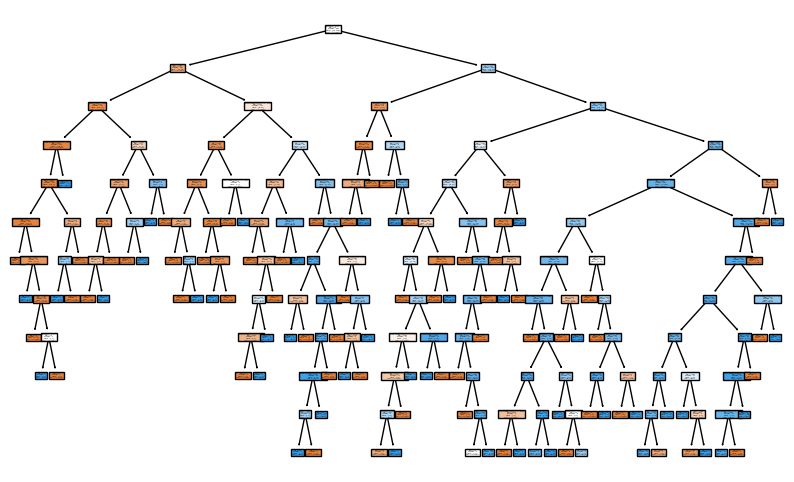

In [72]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=X.columns # careful with what is X 

plot_tree(
    dt_model,
    feature_names=feature_names, 
    class_names=['non-diabetic','diabetic'], 
    filled=True
)

plt.show()

## 2.4 Feature importance

In [73]:
# feature importance
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

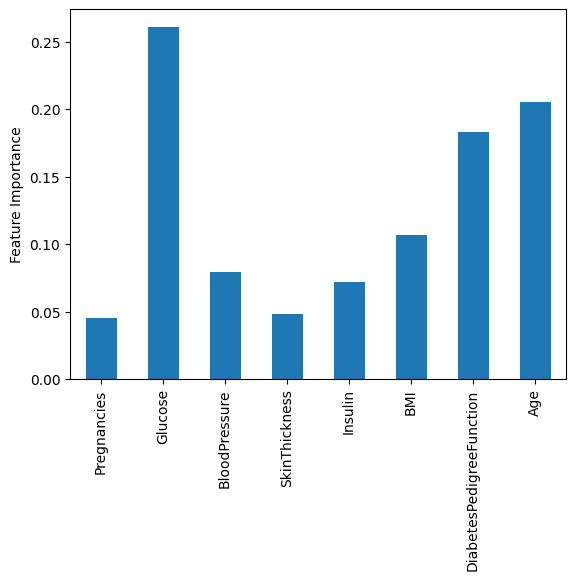

In [74]:
# Plot feature importance
plot_importances(dt_model.feature_importances_, feature_names)

# 3. Random Forest (RF)

We are going to build a Random Forest Model and try to optimize the model by tuning max_depth

## All parameter in one optimization

best mean cross-validation score: 0.836
best parameters: {'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 100}
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	99.55	80.07
SEN:	100.00	87.16
ESP:	99.11	72.46
PPV:	99.09	77.25
F1:	99.54	81.90


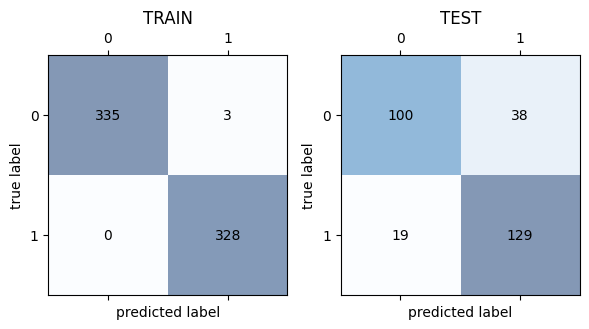

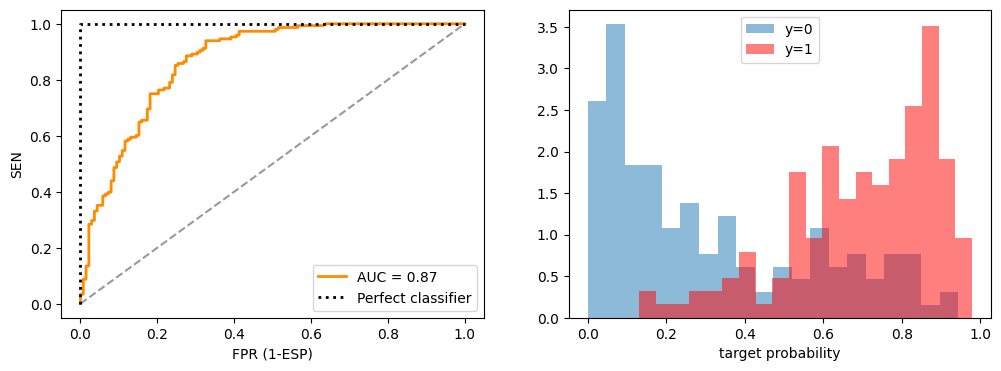

In [85]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
param_grid = {'max_depth': range(1,15), 'n_estimators' : [50,100,200,500,1000], 'min_samples_split': range(2,10)} # 

# Model selection
scorer = 'accuracy'
estimator = RandomForestClassifier(random_state=0)

#HYPER PARAMETER SEARCH
grid_rf = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
#plot_cv_scoring(grid_rf,'max_depth',scorer, plot_errors=True)

rf_model =  RandomForestClassifier(random_state=0, **grid_rf.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(rf_model,X_train_norm,X_test_norm,y_train,y_test)

Overfitting, can quit min_samples_split (always put 2). 

### Parameter by parameter

best mean cross-validation score: 0.836
best parameters: {'max_depth': 12}


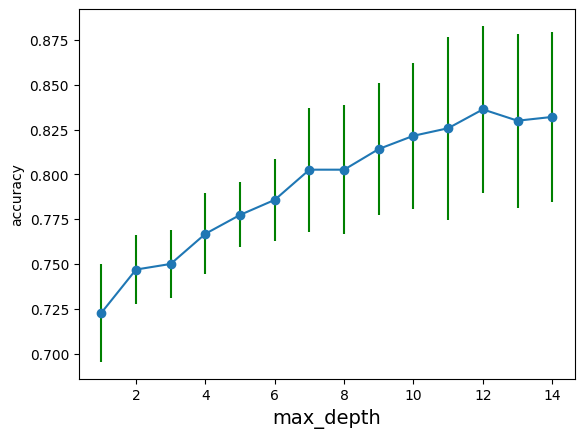

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
param_grid = {'max_depth': range(1,15)} # 'n_estimators' : [50,100,200,500,1000]

# Model selection
scorer = 'accuracy'
estimator = RandomForestClassifier(random_state=0)

#HYPER PARAMETER SEARCH
grid_rf = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_rf,'max_depth',scorer, plot_errors=True)

## Minimum samples split

best mean cross-validation score: 0.828
best parameters: {'min_samples_split': 2}


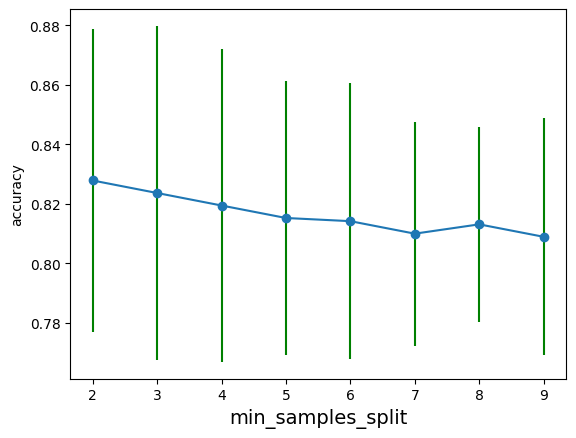

In [82]:
# Random Forest
param_grid = {'min_samples_split': range(2,10)} # 'n_estimators' : [50,100,200,500,1000]

# Model selection
scorer = 'accuracy'
estimator = RandomForestClassifier(random_state=0)

#HYPER PARAMETER SEARCH
grid_rf2 = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_rf2,'min_samples_split',scorer, plot_errors=True)

### Number of estimator tuning

best mean cross-validation score: 0.827
best parameters: {'n_estimators': 1000}


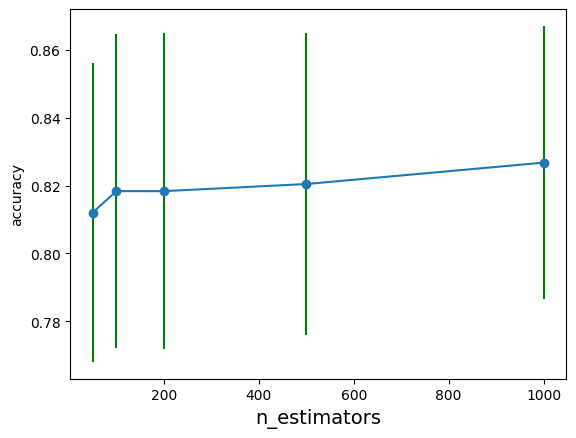

In [83]:
# Random Forest
param_grid = {'n_estimators' : [50,100,200,500,1000]} 

# Model selection
scorer = 'accuracy'
estimator = RandomForestClassifier(random_state=0, min_samples_split=4, max_depth=13)

#HYPER PARAMETER SEARCH
grid_rf3 = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

# do the plotting
plot_cv_scoring(grid_rf3,'n_estimators',scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	99.55	79.37
SEN:	100.00	85.14
ESP:	99.11	73.19
PPV:	99.09	77.30
F1:	99.54	81.03


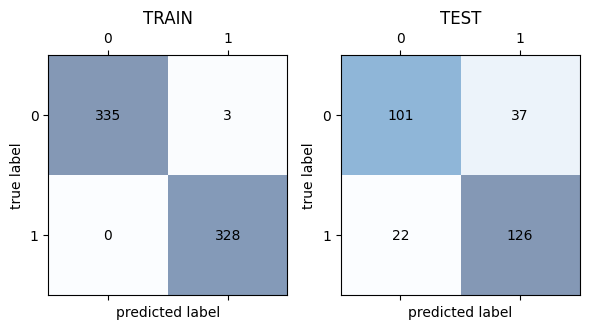

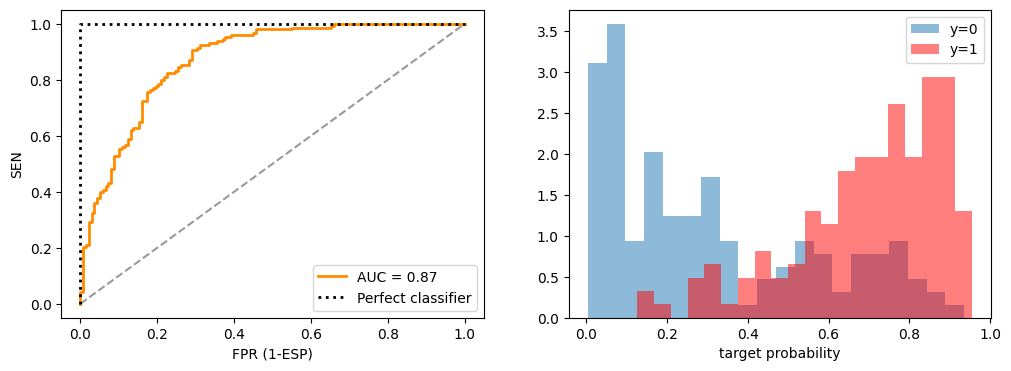

In [84]:
best_max_depth = grid_rf.best_params_['max_depth']
best_min_samples_split = grid_rf2.best_params_['min_samples_split']
best_n_estimators = grid_rf3.best_params_['n_estimators']

rf_model = RandomForestClassifier(random_state=0, max_depth=best_max_depth, min_samples_split=best_min_samples_split, n_estimators=best_n_estimators).fit(X_train_norm,y_train)
analyze_train_test_performance(rf_model,X_train_norm,X_test_norm,y_train,y_test)

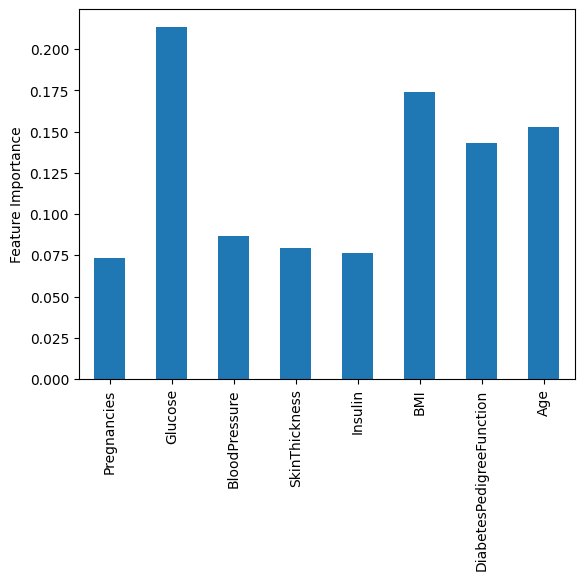

In [94]:
plot_importances(rf_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?
- Try another hyperparameter along with max_depth and without tuning n_estimators and once the two hyperparameters are selected increase the number of estimators. Is it better the performance?

</div>

It overfits. \
Slightly better than baseline \
Glucose, BMI and Age. 

# 4. Gradient Boosting (trees) (BT)

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators' : [50,100,200,500],#, 1000, 2000],
    'learning_rate': [0.1,0.05,0.01, 0.005, 0.001], 
    'max_depth': [1, 2]
} 

estimator = GradientBoostingClassifier(random_state=0)
scorer = 'accuracy'

#hyper parameter search 
grid_gbc = hyper_parameters_search(estimator, X_norm, y, param_grid, scorer=scorer, cv=5)

best mean cross-validation score: 0.798
best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	97.75	79.02
SEN:	98.78	82.43
ESP:	96.75	75.36
PPV:	96.72	78.21
F1:	97.74	80.26


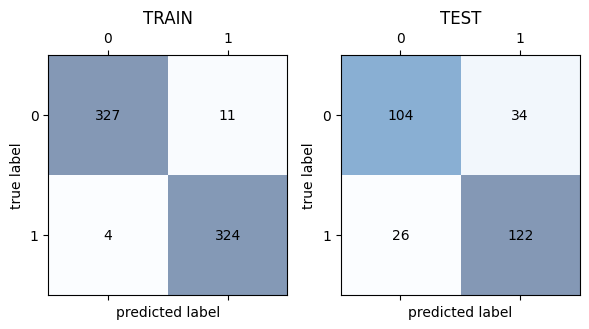

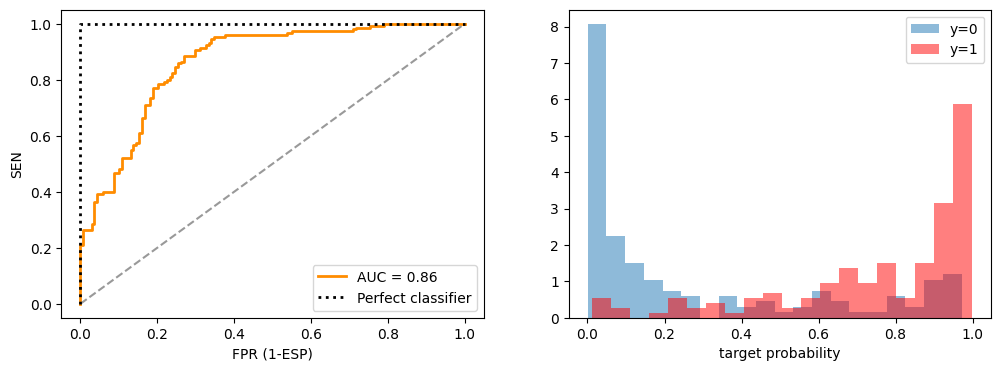

In [87]:
# 4.2 Model evaluation

# we don't plot bc there are too many parameters

gbc_model =  GradientBoostingClassifier(random_state=0, **grid_gbc.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(gbc_model,X_train_norm,X_test_norm,y_train,y_test)



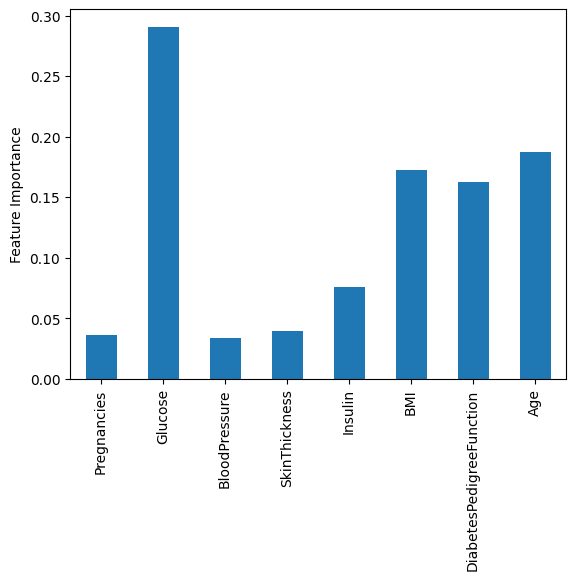

In [88]:
# 4.3 Feature importance
plot_importances(gbc_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 5. Multilayer Perceptron (MLP)

We are going to build a MLP with 
* 1 hidden layer 5 units
* 1 hidden layer 10 units
* 2 hidden layers 5 units.


In [99]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier

param_grid = {
    'alpha' : 10.0 ** -np.arange(2, 4), # following recommendation: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use
    'hidden_layer_sizes': np.arange(1, 50, 4)
} 

# 5.1 Model selection ...

model = MLPClassifier(random_state=0, max_iter=1000)
scorer = 'accuracy'

#hyper_parameters_search()
grid_mlp = hyper_parameters_search(model, X_norm, y, param_grid, scorer=scorer, cv=5)


best mean cross-validation score: 0.798
best parameters: {'alpha': 0.01, 'hidden_layer_sizes': 33}


{'alpha': 0.01, 'hidden_layer_sizes': 33}
PERFORMANCE METRICS
	TRAIN	TEST
ACC:	81.83	72.38
SEN:	84.76	75.00
ESP:	78.99	69.57
PPV:	79.66	72.55
F1:	82.13	73.75


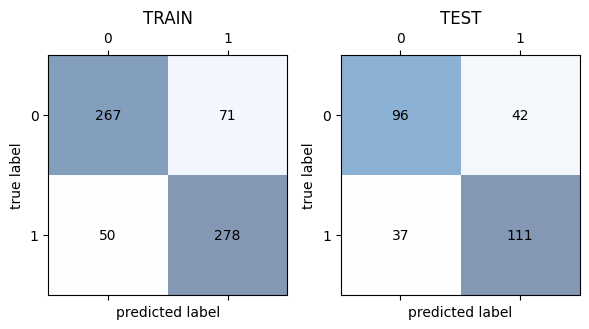

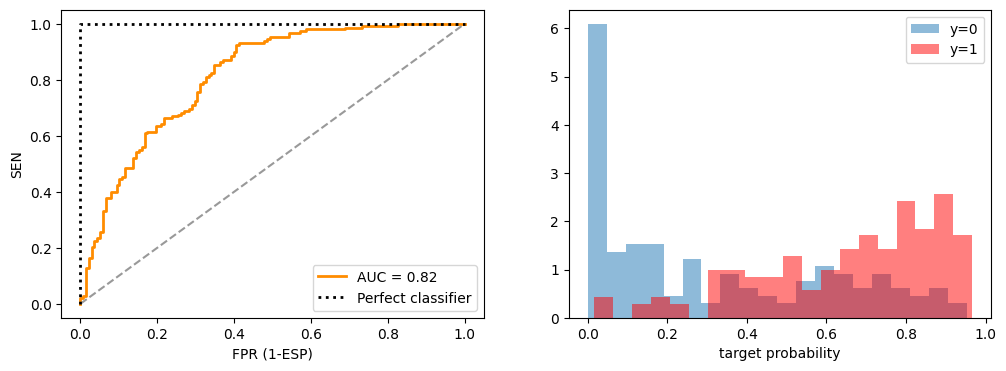

In [100]:
# 5.2 Model evaluation

# your code here
print(grid_mlp.best_params_)
mlp_model =  MLPClassifier(random_state=0, **grid_mlp.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(mlp_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 6. Model comparison

If you have done all of the above, just run the following cell

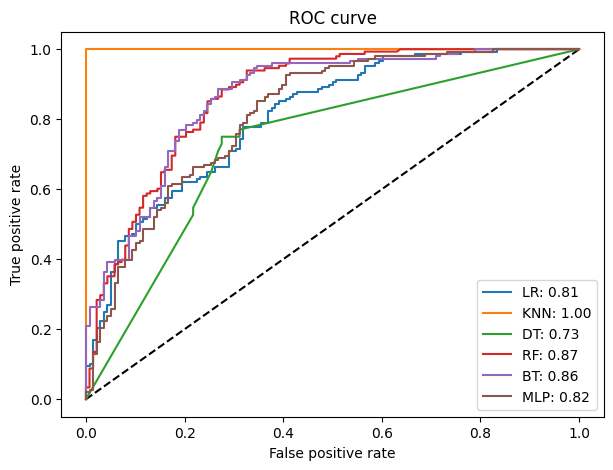

In [101]:
from sklearn.metrics import roc_curve, auc

modelos = {'LR': lr_model, 'KNN':knn_model,'DT':dt_model, 'RF': rf_model, 'BT': gbc_model, 'MLP': mlp_model}

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
for k,v in modelos.items():
    fpr, tpr,_ = roc_curve(y_test, modelos[k].predict_proba(X_test_norm)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = k + ': %0.2f' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

<div class = "alert alert-success">

Taking into account the above results, in your opinion
    
- What is the best model? Justify your answer 
- And the most important feature(s)? 
- If you want to improve these results, what would you do?

</div>

KNN is the best model (100% accuracy, yes we can use that metric bc classes are balanced) \
GLucose, Age, DiabetePedigreeFunction are the most import features \
? already good \
If we plot values for Glucose, Age and DiabetePedigreeFunction according to Outcome feature, we could observe data distribution and understrand
why some models work better than others. 

# 7. Your turn!

<div class = "alert alert-success">

1. Apply non-parametric methods to a regression problem. 
    - Which performance metric would you use?


2. Apply non-parametric methods to your dataset. 

</div> 

# Project Ideas

Here there are some tips that you might want to consider for your project:

1. Select a baseline classifier. Which one did you choose? Why?


2. Compare different machine learning methods. Which one provides you with the best performance? Comment on:
    - ... how you selected the best model (hyperparameters you chose and the performance metric you used to do so)
    - ... model overfitting


3. If you used decision trees or decision trees based algorithms, which are the most important features? Are they coherent with you domain expertise?


In all above, justify your decisions.